# BE Machine Learning
## Bitcoin Heist


#### On choisi tune detection d'annomalie
 
On ne sait pas quel va etre le type du prochain ransomware donc on prefere etre sur de detecetr un white que essayer de chercher les ransomware


In [4]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [5]:
# load the dataset in a pandas DataFrame
df = pd.read_csv('data/BitcoinHeistData.csv')

In [6]:
# first visualization

print(f"dataset shape: {df.shape}")
print(f"columns names: {df.columns.tolist()}")
print(df.head())

labels_names = df['label'].unique().tolist()
print(labels_names)

dataset shape: (2916697, 10)
columns names: ['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income', 'label']
                              address  year  day  length    weight  count  \
0   111K8kZAEnJg245r2cM6y9zgJGHZtJPy6  2017   11      18  0.008333      1   
1  1123pJv8jzeFQaCV4w644pzQJzVWay2zcA  2016  132      44  0.000244      1   
2  112536im7hy6wtKbpH1qYDWtTyMRAcA2p7  2016  246       0  1.000000      1   
3  1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7  2016  322      72  0.003906      1   
4  1129TSjKtx65E35GiUo4AYVeyo48twbrGX  2016  238     144  0.072848    456   

   looped  neighbors       income            label  
0       0          2  100050000.0  princetonCerber  
1       0          1  100000000.0   princetonLocky  
2       0          2  200000000.0  princetonCerber  
3       0          2   71200000.0  princetonCerber  
4       0          1  200000000.0   princetonLocky  
['princetonCerber', 'princetonLocky', 'montrealCryptoLocker', 'montrealCryptX

### Traitement des données

On change les label pour etre 0 si c'est white ou 1 si c'est un ransomware

In [7]:
df['y'] = (df['label'] != 'white').astype(int)
df_white = df[df['y'] == 0]
df_ransomware = df[df['y'] == 1]
print(f"il y a {len(df_white)} adresses blanches et {len(df_ransomware)} ransomwares")
print(f"proportion de ransomwares: {len(df_ransomware) / len(df)}")

il y a 2875284 adresses blanches et 41413 ransomwares
proportion de ransomwares: 0.014198595191752863


In [8]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

On créé maintenant les X et y

In [ ]:
# base features
features = ['length','weight','count','looped','neighbors','income']
X = df[features].copy()
y = df['y'].values

# Derived features
# add small constants in denominators to avoid division by zero
X['merge_efficiency'] = X_feat['weight'] / (X['count'] + 1)
X['loop_ratio'] = X['looped'] / (X['count'] + 1)
X['mix_complexity'] = X['length'] * X['count']
X['income_per_neighbor'] = X['income'] / (X['neighbors'] + 1)
X['mix_intensity'] = (X['length'] + X['looped']) / (X['neighbors'] + 1)

# append derived features to the features list so they are included downstream
derived = ['merge_efficiency','loop_ratio','mix_complexity','income_per_neighbor','mix_intensity']
features = features + derived
X

# optionally transform skewed numeric columns (log1p) for a subset of features
'''
to_log = ['income', 'weight', 'count', 'length']
# guard: only apply if columns exist in X
to_log = [c for c in to_log if c in X.columns]
X[to_log] = np.log1p(X[to_log])
'''


"\nto_log = ['income', 'weight', 'count', 'length']\n# guard: only apply if columns exist in X\nto_log = [c for c in to_log if c in X.columns]\nX[to_log] = np.log1p(X[to_log])\n"

## Première idée sur Random forest -> pas fou

Importance de mettre **class_weight='balanced'**

In [11]:
"""rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,
    class_weight='balanced',  # très important car dataset déséquilibré
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
"""

"rf = RandomForestClassifier(\n    n_estimators=1000,\n    max_depth=10,\n    class_weight='balanced',  # très important car dataset déséquilibré\n    n_jobs=-1,\n    random_state=42\n)\n\nrf.fit(X_train, y_train)\n"

In [12]:
"""y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print("ROC-AUC :", roc_auc_score(y_test, y_prob))
print("PR-AUC :", average_precision_score(y_test, y_prob))
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))
"""

'y_pred = rf.predict(X_test)\ny_prob = rf.predict_proba(X_test)[:,1]\n\nprint("ROC-AUC :", roc_auc_score(y_test, y_prob))\nprint("PR-AUC :", average_precision_score(y_test, y_prob))\nprint(classification_report(y_test, y_pred, digits=4))\nprint(confusion_matrix(y_test, y_pred))\n'

In [13]:
""""
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance - Random Forest")
plt.show()
"""

'"\nimportances = rf.feature_importances_\nsorted_idx = np.argsort(importances)[::-1]\n\nplt.barh(np.array(features)[sorted_idx], importances[sorted_idx])\nplt.xlabel("Importance")\nplt.title("Feature Importance - Random Forest")\nplt.show()\n'

## Implémentation d'un novelty search

In [33]:

X_attack = df[features][y == 1].copy()
y_attack = df['y'][y == 1].values
X_clean = df[features][y == 0].copy()
y_clean = df['y'][y == 0].values

X_clean.head()


,length,weight,count,looped,neighbors,income
41413,0,1.0,1,0,1,5.000000e+09
41414,0,1.0,1,0,2,5.000000e+09
41415,0,1.0,1,0,2,9.150000e+08
41416,0,1.0,1,0,2,3.402500e+10
41417,0,1.0,1,0,2,1.275100e+10


## Isolation forest tentative

In [15]:
""""
from sklearn.ensemble import IsolationForest

X_train = X.sample(frac=0.8, random_state=42)
X_test = X.drop(X_train.index)
y_train = y[X_train.index]
y_test = y[X_test.index]

# Crée et entraîne le modèle Isolation Forest
clf = IsolationForest(n_estimators=1000, contamination=0.1, random_state=42)
clf.fit(X_train)
# Prédit les anomalies sur l'ensemble de test
y_pred = clf.predict(X_test)

erreur_faux = (y_pred == 0) & (y_test == 1)
print(f"Nombre d'erreurs (faux négatifs) : {erreur_faux.sum()}")

erreur_vrai = (y_pred == 1) & (y_test == 0)

print(f"Nombre d'erreurs (faux positifs) : {erreur_vrai.sum()}")
"""


'"\nfrom sklearn.ensemble import IsolationForest\n\nX_train = X.sample(frac=0.8, random_state=42)\nX_test = X.drop(X_train.index)\ny_train = y[X_train.index]\ny_test = y[X_test.index]\n\n# Crée et entraîne le modèle Isolation Forest\nclf = IsolationForest(n_estimators=1000, contamination=0.1, random_state=42)\nclf.fit(X_train)\n# Prédit les anomalies sur l\'ensemble de test\ny_pred = clf.predict(X_test)\n\nerreur_faux = (y_pred == 0) & (y_test == 1)\nprint(f"Nombre d\'erreurs (faux négatifs) : {erreur_faux.sum()}")\n\nerreur_vrai = (y_pred == 1) & (y_test == 0)\n\nprint(f"Nombre d\'erreurs (faux positifs) : {erreur_vrai.sum()}")\n'

## Data Engineering

### Tests right-skewedness

NameError: name 'positive' is not defined

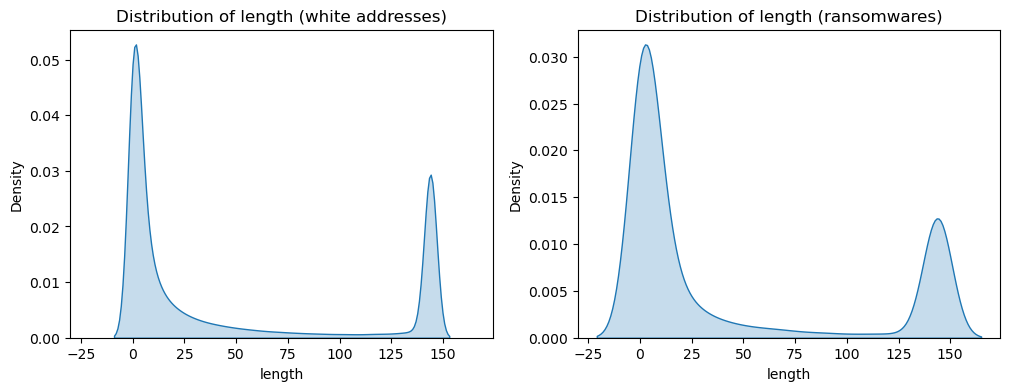

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']
for col in features:
    # determine common x-limits for fair comparison (use log scale if data is positive)
    data_all = pd.concat([df_white[col], df_ransomware[col]])
    # if values are strictly positive, we can show log-scaled kde; else keep linear
    #positive = (data_all > 0).all()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    '''
    if positive:
        sns.kdeplot(data=df_white, x=col, common_norm=False, ax=axes[0], log_scale=True, fill=True, bw_method='scott')
        axes[0].set_title(f'Distribution of {col} (white addresses) - log scale')
        sns.kdeplot(data=df_ransomware, x=col, common_norm=False, ax=axes[1], log_scale=True, fill=True, bw_method='scott')
        axes[1].set_title(f'Distribution of {col} (ransomwares) - log scale')
    else:
    '''
    sns.kdeplot(data=df_white, x=col, common_norm=False, ax=axes[0], fill=True, bw_method='scott')
    axes[0].set_title(f'Distribution of {col} (white addresses)')
    sns.kdeplot(data=df_ransomware, x=col, common_norm=False, ax=axes[1], fill=True, bw_method='scott')
    axes[1].set_title(f'Distribution of {col} (ransomwares)')

    # set same x-limits for comparison
    xmin, xmax = data_all.min(), data_all.max()
    if positive:
        if xmin <= 0: xmin = data_all[data_all>0].min()
        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
    axes[0].set_xlim(xmin, xmax)

    plt.tight_layout()
    plt.show()


We will try using both raw and log values of each feature to determine which has most imoprtance

In [ ]:
# adding the log features to see if they improve model performance
X_log = X.copy()
for feature in features:
    X_log[f'log_{feature}'] = np.log1p(X_log[feature])      


In [ ]:
X_train = X.sample(frac=0.8, random_state=42)
X_test = X.drop(X_train.index)
y_train = y[X_train.index]
y_test = y[X_test.index]


In [ ]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',  # très important car dataset déséquilibré
    n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78    574995
           1       0.03      0.80      0.06      8344

    accuracy                           0.64    583339
   macro avg       0.51      0.72      0.42    583339
weighted avg       0.98      0.64      0.77    583339

[[369014 205981]
 [  1689   6655]]

 aucune diff en passant de 300 à 500 de depth

### Test des features de combinaisons linéaires

In [20]:
# base features
features = ['length','weight','count','looped','neighbors','income']
X_feat = X[features].copy()

# Derived features
# add small constants in denominators to avoid division by zero
X_feat['merge_efficiency'] = X_feat['weight'] / (X_feat['count'] + 1)
X_feat['loop_ratio'] = X_feat['looped'] / (X_feat['count'] + 1)
X_feat['mix_complexity'] = X_feat['length'] * X_feat['count']
X_feat['income_per_neighbor'] = X_feat['income'] / (X_feat['neighbors'] + 1)
X_feat['mix_intensity'] = (X_feat['length'] + X_feat['looped']) / (X_feat['neighbors'] + 1)


# optionally transform skewed numeric columns (log1p) for a subset of features
'''
to_log = ['income', 'weight', 'count', 'length']
# guard: only apply if columns exist in X
to_log = [c for c in to_log if c in X.columns]
X[to_log] = np.log1p(X[to_log])
'''

"\nto_log = ['income', 'weight', 'count', 'length']\n# guard: only apply if columns exist in X\nto_log = [c for c in to_log if c in X.columns]\nX[to_log] = np.log1p(X[to_log])\n"

In [37]:
# Sample 80% for training, 20% for testing
X_attack_train = X_attack.sample(frac=0.8, random_state=42)
X_clean_train = X_clean.sample(frac=0.8, random_state=42)

train_indices = X_attack_train.index.append(X_clean_train.index)
test_indices = X_feat.index.difference(train_indices)

X_train_feat = X_feat.loc[train_indices]
X_test_feat = X_feat.loc[test_indices]
y_train_feat = y[train_indices]
y_test_feat = y[test_indices]

In [ ]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    #class_weight='balanced',  # très important car dataset déséquilibré
    n_jobs=-1)
model.fit(X_train_feat, y_train_feat)

y_pred_feat = model.predict(X_test_feat)
print(classification_report(y_test_feat, y_pred_feat))
print(confusion_matrix(y_test_feat, y_pred_feat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    575057
           1       0.89      0.00      0.00      8283

    accuracy                           0.99    583340
   macro avg       0.94      0.50      0.50    583340
weighted avg       0.98      0.99      0.98    583340

[[575055      2]
 [  8266     17]]


In [39]:
print(confusion_matrix(y_pred_feat, y_test_feat))

[[575055   8266]
 [     2     17]]
